In [1]:
import autoencodeSVJ.utils as utils

version = 'v1'
hlf = True
eflow = True
eflow_base = 3
signal_path = "data/signal/base_{}/*.h5".format(eflow_base)
qcd_path = "data/background/base_{}/*.h5".format(eflow_base)

(signal,
 signal_jets,
 signal_event,
 signal_flavor) = utils.load_all_data(
    signal_path,
    "signal", include_hlf=hlf, include_eflow=eflow
)

(qcd,
 qcd_jets,
 qcd_event,
 qcd_flavor) = utils.load_all_data(
    qcd_path, 
    "qcd background", include_hlf=hlf, include_eflow=eflow
)


### data checking, etc. 
uncomment the following lines to see training and signal data comparisons. commented out for simplicity here

In [2]:
# utils.jet_flavor_check(qcd_flavor)
# utils.jet_flavor_check(signal_flavor)

# signal.plot(utils.jet_flavor_split(qcd, qcd_flavor), normed='n', figname='signal vs. different jet signals', bins=50, figsize=20)

In [3]:
import autoencodeSVJ.models as models
import autoencodeSVJ.trainer as trainer
import os

seed = 40

import numpy as np
import tensorflow as tf

np.random.seed(seed)
tf.set_random_seed(seed)

target_dim = 8
input_dim = len(signal.columns)
test_split = 0.15
val_split = 0.15

filename = "{}_{}_{}_{}".format('hlf' if hlf else '', 'eflow' if eflow else '', target_dim, version)

norm_args = {
    "norm_type": "StandardScaler"
}

data_args = {
    'target_dim': target_dim,
    'input_dim': input_dim,
    'test_split': test_split,
    'val_split': val_split,
    'hlf': hlf, 
    'eflow': eflow,
    'eflow_base': eflow_base,
    'seed': seed,
    'filename': filename,
    'filepath': os.path.abspath(filename),
}

custom_objects = {
    
}

all_train, test = qcd.train_test_split(test_split, seed)
train, val = all_train.train_test_split(val_split, seed)

train_norm = train.norm(out_name="qcd train norm", **norm_args)
val_norm = train.norm(val, out_name="qcd val norm", **norm_args)
 
test_norm = test.norm(out_name="qcd test norm", **norm_args)
signal_norm = signal.norm(out_name="signal norm", **norm_args)

train.name = "qcd training data"
test.name = "qcd test data"
val.name = "qcd validation data"

instance = trainer.trainer(filename)

aes = models.base_autoencoder()
aes.add(input_dim)
aes.add(30, activation='relu')
aes.add(30, activation='relu')
aes.add(target_dim, activation='relu')
aes.add(30, activation='relu')
aes.add(30, activation='relu')
aes.add(input_dim, activation='linear')

ae = aes.build()
ae.summary()

Using TensorFlow backend.


h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'hlf_eflow_8_v1.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'hlf_eflow_8_v1.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'hlf_eflow_8_v1.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'hlf_eflow_8_v1.h5'
h5_elt 'lr' :: loading dataset 'metric_names/lr' from file 'hlf_eflow_8_v1.h5'
h5_elt 'val_loss' :: loading dataset 'metric_names/val_loss' from file 'hlf_eflow_8_v1.h5'
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 19)                0         
_________________________________________________________________
encoder (Model)              (None, 8)                 1778      
_________________________________________________________________
decoder (Model)              (None, 19)                1789      
Total params: 3,567
Trainabl

commented plot; this shows training, testing, and validation dataset comparisons

In [4]:
# train.plot([val,test], normed=1, figname='training, testing, and evaluation qcd data', bins=60)

In [5]:
train_args = {
    'batch_size': 64, 
    'loss': 'mse', 
    'optimizer': 'adam',
    'epochs': 100,
    'learning_rate': 0.0005,
}

do_train = False
if do_train:
    ae = instance.train(
        x_train=train_norm.data,
        x_test=val_norm.data,
        y_train=train_norm.data,
        y_test=val_norm.data,
        model=ae,
        force=True,
        use_callbacks=True,
        custom_objects=custom_objects, 
        **train_args
    )
else:
    ae = instance.load_model(custom_objects=custom_objects)

train_shell :: using saved model


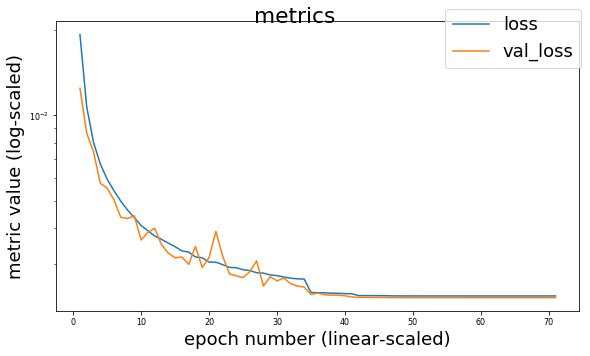

In [6]:
instance.plot_metrics(figsize=(8,5), figname="metrics", yscale='log', figloc='upper right')

### get reconstructions, errors, and node representatives

In [7]:
[data_err, signal_err], [data_recon, signal_recon] = utils.get_recon_errors([test_norm, signal_norm], ae)

data_reps = utils.data_table(ae.layers[1].predict(test_norm.data), name='background reps')
signal_reps = utils.data_table(ae.layers[1].predict(signal_norm.data), name='signal reps')

data_table :: plotting distrubution(s) for table(s) ['qcd test norm pred', 'qcd test norm']


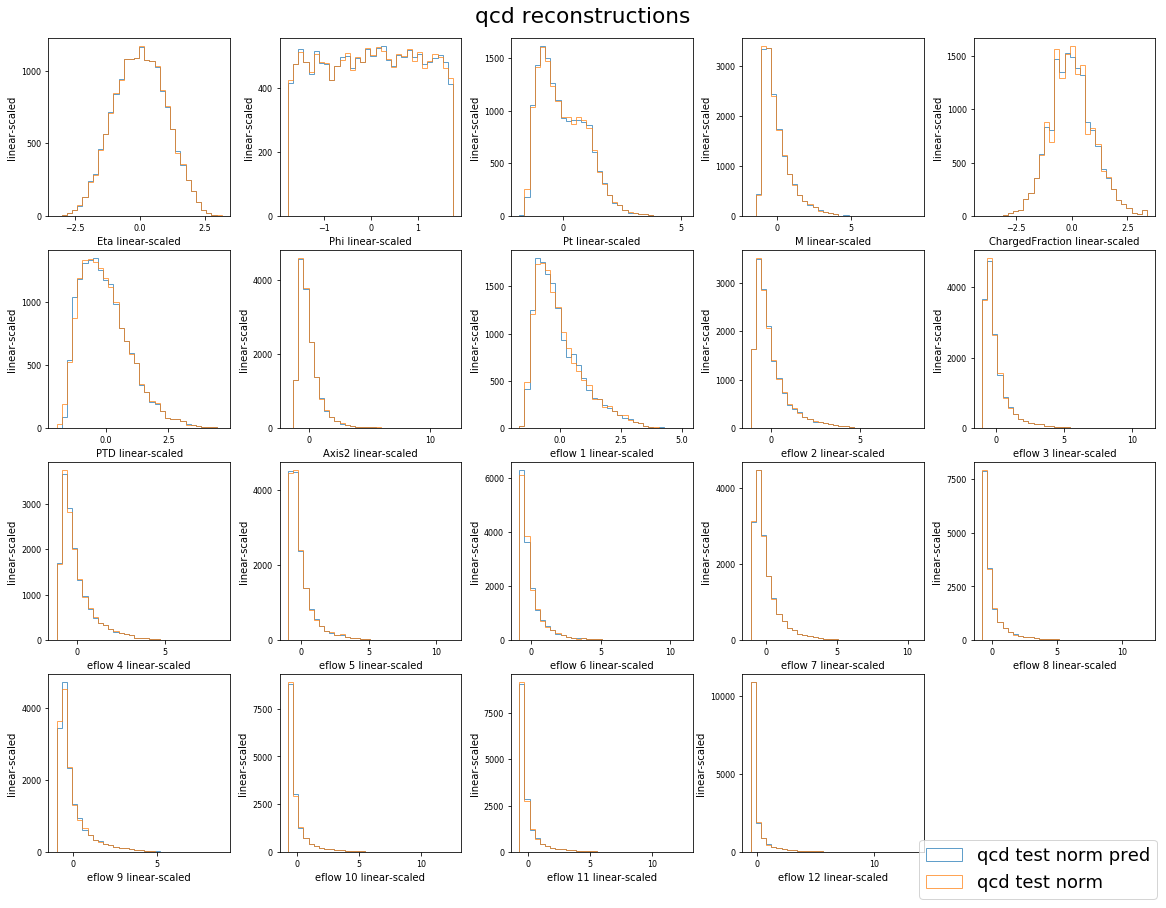

data_table :: plotting distrubution(s) for table(s) ['signal norm pred', 'signal norm']


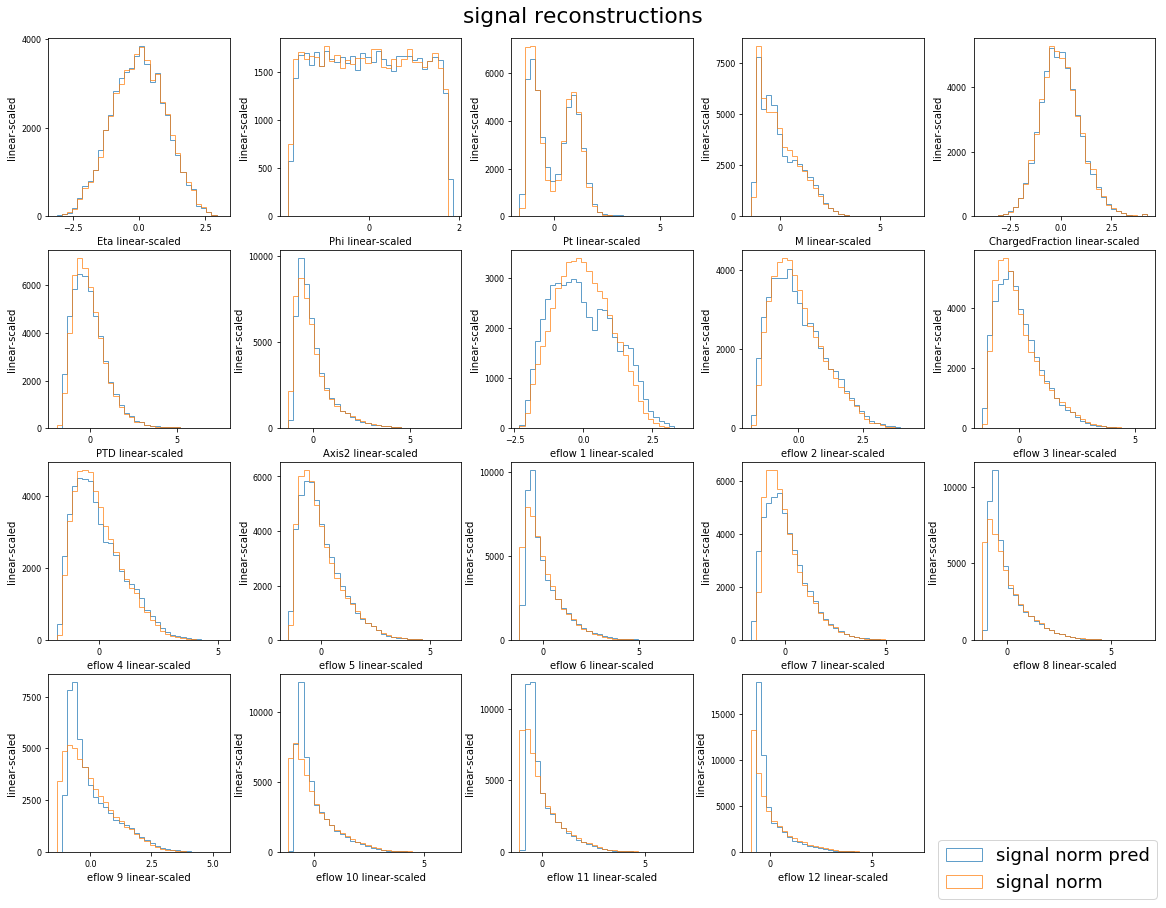

In [8]:
data_recon.plot(test_norm, figname='qcd reconstructions', cols=5)
signal_recon.plot(signal_norm, figname='signal reconstructions', cols=5) 

data_table :: plotting distrubution(s) for table(s) ['background reps', 'signal reps']


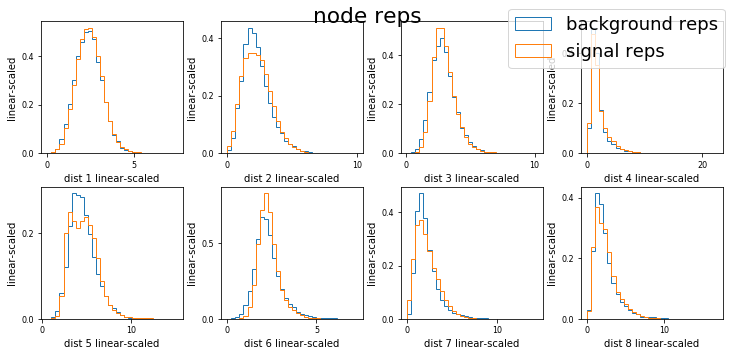

In [9]:
data_reps.plot(signal_reps, alpha=1, normed=1, figname='node reps', figsize=10, figloc='upper right', cols=4)

data_table :: plotting distrubution(s) for table(s) ['qcd test norm error', 'signal norm error']


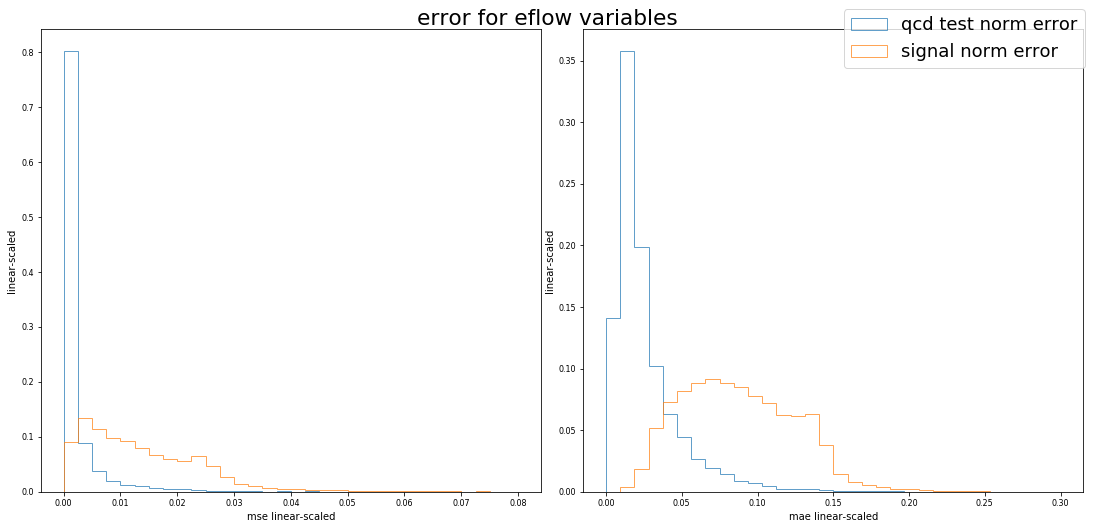

In [10]:
data_err.plot(
    signal_err, figsize=15, normed='n', 
    figname='error for eflow variables', 
    yscale='linear', rng=((0, 0.08), (0, 0.3)), 
    figloc="upper right"
)

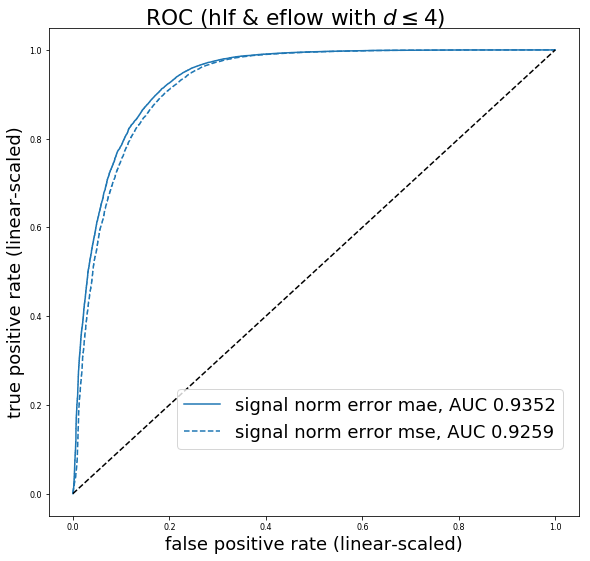

In [11]:
utils.roc_auc_plot(data_err, signal_err, metrics=['mae', 'mse'], figsize=8, figname='ROC (hlf & eflow with $d\leq4$)', figloc=(0.3, 0.2))
roc_dict = utils.roc_auc_dict(data_err, signal_err, metrics=['mae', 'mse']).values()[0]
result_args = dict([(r + '_auc', roc_dict[r]['auc']) for r in roc_dict])

In [12]:
utils.dump_summary_json(result_args, train_args, norm_args, data_args)

mse_auc : 0.925902945502
mae_auc : 0.935167560254
epochs : 100
loss : mse
learning_rate : 0.0005
optimizer : adam
batch_size : 64
norm_type : StandardScaler
seed : 40
input_dim : 19
target_dim : 8
test_split : 0.15
hlf : True
val_split : 0.15
filepath : /afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/notebooks/ae/eflow/hlf_eflow_8_v1
eflow : True
eflow_base : 3
filename : hlf_eflow_8_v1

successfully dumped size-19 summary dict to file '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow_8_v1.summary'
